# Intro to Nested Sampling with Gleipnir

In addition to Gleipnir and its dependencies, you will also need matplotlib installed to run this notebook in whole.

## What is Gleipnir?

Gleipnir is a python toolkit that provides an easy to use interface for Nested Sampling that is similar to the calibration tools [PyDREAM](https://github.com/LoLab-VU/PyDREAM) and [SimplePSO](https://github.com/LoLab-VU/ParticleSwarmOptimization). Gleipnir has a built-in implementation of the classic Nested Sampling algorithm, and the toolkit provides a common interface to the Nested Sampling implementations MultiNest, PolyChord, and DNest4. Gleipnir also has some PySB model-specific utilities, including nestedsample_it/NestedSampleIt and HypSelector. 

Through Nested Sampling simulations, Gleipnir can be used to compute the Bayesian evidence (or marginal likelihood) of models. The Bayesian evidence can in turn be used for model selection; i.e., users can select between competing models and determine which one is best supported by the data. And as a side-effect of the evidence calculation, estimates of the posterior distributions of the parameters can also be generated; therefore, Gleipnir can also be used for Bayesian model calibration. 

## Eggcarton likelihood model

In this tutorial, we will cover the basics of setting up and running Nested Sampling simulations of the Egg Carton likelihood landscape using Gleipnir; this example was adapted from the [pymultinest_demo.py](https://github.com/JohannesBuchner/PyMultiNest/blob/master/pymultinest_demo.py). 

For the puroposes of this tutorial, we will use Gleipnir's built-in Nested Sampling implementation; we will cover the interfaces to different Nested Samplers available from Gleipnir in a separate tutorial. 

The Egg Carton likelihood landscape is a common test case for Bayesian sampling schemes. The model is typically two-dimensional (two parameters) and the landscape generated by the likelihood function is a multi-modal egg carton-like shape; see slide 15 of [this pdf](http://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2016/Lecture14_MultiNest.pdf) for a visualization of the likelihood landscape. The parameters are each defined on \[0:10pi\] with uniform priors. 

Here is the Egg Carton loglikelihood function which returns the natural logarithm of the likelihood for a given parameter vector:

In [1]:
# Import NumPy
import numpy as np
# Define the loglikelihood function.
def loglikelihood(parameter_vector):
    chi = (np.cos(parameter_vector)).prod()
    return (2. + chi)**5

### Sampled Parameters

Now that we have our loglikelihood function, let's look at how to define parameters for sampling during the Nested Sampling run. The parameters that are sampled are defined by a list of SampledParameter class instances. The SampledParameter class object stores data on the name of the parameter and the parameter's prior probability distribution. 

In [2]:
# Import the SampledParameters class.
from gleipnir.sampled_parameter import SampledParameter

A new SampledParameter needs two arguments: a name and a object defining the prior.

For priors we can use frozen RV objects from scipy.stats; in special cases you could also write your own prior distribution class objects, but for most purposes scipy.stats distributions will be sufficient.

In [3]:
# Let's import the uniform distribution.
from scipy.stats import uniform

In [4]:
# Now we'll create our list sampled parameters.
# There are two parameters 'x' and 'y',each with a uniform prior on [0:10pi]. 
sampled_parameters = list()
sampled_parameters.append(SampledParameter(name='x', prior=uniform(loc=0.0,scale=10.0*np.pi)))
sampled_parameters.append(SampledParameter(name='y', prior=uniform(loc=0.0,scale=10.0*np.pi)))  

Now we've defined our list of paramters that are to be sampled and their prior probability distributions.  

### The Nested Sampler

Now that we have the loglikelihood function and the sampled parameters setup, let's create our Nested Sampler. First, let's do all our imports.

In [5]:
# Import the Nested Sampler class object.
from gleipnir.nested_sampling import NestedSampling
# Import the sampler we want to use during the Neseted Sampling run.
# In this case, we'll use a Metropololis Monte Carlo sampler adapted for Nested Sampling.
from gleipnir.samplers import MetropolisComponentWiseHardNSRejection
# Import the stopping criterion object. In this case, we'll use a fixed number of iterations.
from gleipnir.stopping_criterion import NumberOfIterations

Now we need to consider the size of our active point population size to use during the Nested Sampling run. For this tutorial, we'll start with 1000. 

In [6]:
# Set the Nested Sampling active point population size.
population_size = 1000

Now, we need to initialize our sampler and stopping criterion objects:

In [7]:
# Initialize the sampler.
sampler = MetropolisComponentWiseHardNSRejection(iterations=20, tuning_cycles=1)
# Initialize the stopping criterion -- We'll stop after 10*population_size Nested Samping iterations.
stopping_criterion = NumberOfIterations(10*population_size)

We've defined our loglikelihood function, our list of sampled parameters, the sampler, and the stopping criterion. We're ready to initialize our Nested Sampling object. 

In [8]:
# Construct the Nested Sampler -- Using the MCMC sampler with hard rejection
# of likelihood levels is an implementation of the classic Nested Sampling algorithm.
NS = NestedSampling(sampled_parameters=sampled_parameters,
                    loglikelihood=loglikelihood, sampler=sampler,
                    population_size=population_size,
                    stopping_criterion=stopping_criterion)

To run the NestedSampling instance we call the run function; the run function has an optional keyword argument 'verbose', which can use to turn on verbose outputs to the standard output during the run. 

In [9]:
# Run Nested Sampling. - The run function returns a tuple with the log_evidence and its error estimate.
log_evidence, log_evidence_error = NS.run(verbose=True)

Generating the initial set of live points with population size 1000...
Evaluating the loglikelihood function for each live point...
Iteration: 1 Evidence estimate: 0.0027463754411068656 Remaining prior mass: 0.999000999000999
Dead Point:
{'log_l': 1.011281521241717, 'weight': 0.0009990009990009652, 'x': 21.93144650756911, 'y': 25.16325079797916}
Iteration: 10 Evidence estimate: 0.029237196264116177 +- 1.0702665902062451 Remaining prior mass: 0.9900547807130033
Dead Point:
{'log_l': 1.1417512274832868, 'weight': 0.0009900547807129012, 'x': 12.375216553766908, 'y': 3.274456269601044}
Iteration: 20 Evidence estimate: 0.0632852528668728 +- 1.0646730794541528 Remaining prior mass: 0.9802084688126731
Dead Point:
{'log_l': 1.3232972945695352, 'weight': 0.0009802084688126378, 'x': 22.02030574120059, 'y': 31.075991298594765}
Iteration: 30 Evidence estimate: 0.10410026004671978 +- 1.06125041576091 Remaining prior mass: 0.9704600806433599
Dead Point:
{'log_l': 1.5283524398674202, 'weight': 0.0009

Iteration: 340 Evidence estimate: 152932.1072376564 +- 1.0598237992643778 Remaining prior mass: 0.7118912533826006
Dead Point:
{'log_l': 16.168707379198846, 'weight': 0.0007118912533826682, 'x': 8.214785480116733, 'y': 18.086912803267722}
Iteration: 350 Evidence estimate: 231800.74643005908 +- 1.0588557551314728 Remaining prior mass: 0.7048113387592158
Dead Point:
{'log_l': 16.250094721122764, 'weight': 0.0007048113387592148, 'x': 22.99205927164664, 'y': 11.484671431648788}
Iteration: 360 Evidence estimate: 327169.1184626571 +- 1.0578381107491315 Remaining prior mass: 0.6978018354392937
Dead Point:
{'log_l': 16.603091468086397, 'weight': 0.0006978018354392157, 'x': 30.438362798905654, 'y': 16.823185978088762}
Iteration: 370 Evidence estimate: 462864.4723666743 +- 1.0571725081737002 Remaining prior mass: 0.6908620431669812
Dead Point:
{'log_l': 17.058612368114996, 'weight': 0.0006908620431669288, 'x': 8.661186440459446, 'y': 20.086880192917963}
Iteration: 380 Evidence estimate: 700001.1

Iteration: 700 Evidence estimate: 2650894856841.6743 +- 1.0561159150941015 Remaining prior mass: 0.49675902324355803
Dead Point:
{'log_l': 32.28657528579795, 'weight': 0.000496759023243587, 'x': 29.714448385469478, 'y': 1.5981915305945413}
Iteration: 710 Evidence estimate: 3251559636225.006 +- 1.0556515779983682 Remaining prior mass: 0.4918186458246066
Dead Point:
{'log_l': 32.585251541579794, 'weight': 0.0004918186458245932, 'x': 9.471354791222895, 'y': 1.57806698132825}
Iteration: 720 Evidence estimate: 4459809931777.806 +- 1.0563681979013775 Remaining prior mass: 0.4869274015424471
Dead Point:
{'log_l': 33.409627225237564, 'weight': 0.0004869274015424363, 'x': 17.650401314935866, 'y': 17.326466072570167}
Iteration: 730 Evidence estimate: 6197073504512.473 +- 1.0569511324342886 Remaining prior mass: 0.48208480175726
Dead Point:
{'log_l': 33.75351411744883, 'weight': 0.0004820848017572654, 'x': 21.912305347381114, 'y': 17.25723737779322}
Iteration: 740 Evidence estimate: 9987695567010

Iteration: 1050 Evidence estimate: 4.0184159259854976e+18 +- 1.063729199721217 Remaining prior mass: 0.35012139221301253
Dead Point:
{'log_l': 47.398606867738906, 'weight': 0.00035012139221302085, 'x': 27.399430012509406, 'y': 20.678213076731893}
Iteration: 1060 Evidence estimate: 7.149344252823032e+18 +- 1.065001203035998 Remaining prior mass: 0.34663935819038555
Dead Point:
{'log_l': 48.65300192726828, 'weight': 0.0003466393581904037, 'x': 25.942587551508698, 'y': 20.16406004972151}
Iteration: 1070 Evidence estimate: 1.2226488145216377e+19 +- 1.0652474915461614 Remaining prior mass: 0.34319195375967837
Dead Point:
{'log_l': 48.76329915108039, 'weight': 0.0003431919537597028, 'x': 22.805442441541906, 'y': 8.112990870756908}
Iteration: 1080 Evidence estimate: 1.999294863973303e+19 +- 1.0651543673764172 Remaining prior mass: 0.3397788345220056
Dead Point:
{'log_l': 49.37308325950348, 'weight': 0.00033977883452196433, 'x': 20.234200161432742, 'y': 0.20475059900060308}
Iteration: 1090 Evi

Iteration: 1390 Evidence estimate: 1.7875349956834793e+29 +- 1.0709649375980055 Remaining prior mass: 0.24924835673858262
Dead Point:
{'log_l': 72.87088156647366, 'weight': 0.0002492483567385906, 'x': 25.8186410834674, 'y': 24.042634576230505}
Iteration: 1400 Evidence estimate: 3.234522912429812e+29 +- 1.070160583905478 Remaining prior mass: 0.24676952717389383
Dead Point:
{'log_l': 73.28826637375096, 'weight': 0.00024676952717389566, 'x': 16.638152239631854, 'y': 4.06489526048519}
Iteration: 1410 Evidence estimate: 5.374119973237986e+29 +- 1.0693696064279934 Remaining prior mass: 0.24431535011280098
Dead Point:
{'log_l': 73.75092512611916, 'weight': 0.0002443153501127948, 'x': 6.544978105345467, 'y': 23.94775555689567}
Iteration: 1420 Evidence estimate: 1.6715330160153354e+30 +- 1.073565856151292 Remaining prior mass: 0.2418855803807498
Dead Point:
{'log_l': 75.66245108096784, 'weight': 0.0002418855803807407, 'x': 21.34117207289561, 'y': 16.787405526675048}
Iteration: 1430 Evidence es

Iteration: 1730 Evidence estimate: 6.725317495483872e+40 +- 1.0729981936488449 Remaining prior mass: 0.17743772508218317
Dead Point:
{'log_l': 100.13990778210669, 'weight': 0.0001774377250821635, 'x': 22.922214327658683, 'y': 2.603402199921304}
Iteration: 1740 Evidence estimate: 1.2447486496575043e+41 +- 1.07258999785356 Remaining prior mass: 0.17567306799645502
Dead Point:
{'log_l': 100.53879184995282, 'weight': 0.00017567306799645688, 'x': 6.4124575317050105, 'y': 19.87476842810462}
Iteration: 1750 Evidence estimate: 2.1363660881815893e+41 +- 1.0720407789077684 Remaining prior mass: 0.1739259608124108
Dead Point:
{'log_l': 100.97095523862089, 'weight': 0.00017392596081242107, 'x': 27.465157283094587, 'y': 22.715689429914846}
Iteration: 1760 Evidence estimate: 7.976117233969377e+41 +- 1.0762750055214927 Remaining prior mass: 0.17219622899242978
Dead Point:
{'log_l': 102.6701935480085, 'weight': 0.0001721962289924217, 'x': 17.832381746152677, 'y': 18.89780655573614}
Iteration: 1770 Evi

Iteration: 2070 Evidence estimate: 2.5535521485711e+49 +- 1.0701817055092981 Remaining prior mass: 0.1263163645061127
Dead Point:
{'log_l': 119.02553778479454, 'weight': 0.00012631636450610717, 'x': 25.995492737614935, 'y': 24.74036912513579}
Iteration: 2080 Evidence estimate: 3.533001388928611e+49 +- 1.070224335020491 Remaining prior mass: 0.1250601205615632
Dead Point:
{'log_l': 119.80075386836674, 'weight': 0.00012506012056154314, 'x': 26.026847645399044, 'y': 25.398050361344666}
Iteration: 2090 Evidence estimate: 3.1189706936233246e+50 +- 1.0835365278720468 Remaining prior mass: 0.12381637023852021
Dead Point:
{'log_l': 123.31492841062017, 'weight': 0.0001238163702385192, 'x': 10.278871747477803, 'y': 27.934838298818775}
Iteration: 2100 Evidence estimate: 2.5255078923121234e+51 +- 1.0879123152981793 Remaining prior mass: 0.12258498928517816
Dead Point:
{'log_l': 126.81429705865754, 'weight': 0.00012258498928517658, 'x': 9.92727628620952, 'y': 2.379731352583015}
Iteration: 2110 Evid

Iteration: 2410 Evidence estimate: 2.1147040343562173e+59 +- 1.079706625017261 Remaining prior mass: 0.08992351505099001
Dead Point:
{'log_l': 142.90637841869722, 'weight': 8.992351505099361e-05, 'x': 30.666289954274045, 'y': 25.43933813735229}
Iteration: 2420 Evidence estimate: 3.349519610688539e+59 +- 1.078024979420628 Remaining prior mass: 0.08902920597475038
Dead Point:
{'log_l': 143.2650370503622, 'weight': 8.902920597474162e-05, 'x': 13.326198082658088, 'y': 31.148346834047008}
Iteration: 2430 Evidence estimate: 6.101580509337266e+60 +- 1.0922298711411682 Remaining prior mass: 0.08814379099838429
Dead Point:
{'log_l': 148.1261297401228, 'weight': 8.814379099837677e-05, 'x': 22.753343708177407, 'y': 9.294896023049652}
Iteration: 2440 Evidence estimate: 3.6113628233378003e+61 +- 1.0855509375135957 Remaining prior mass: 0.08726718166811816
Dead Point:
{'log_l': 148.74588708683032, 'weight': 8.726718166811309e-05, 'x': 2.3811109767382774, 'y': 28.15672871372233}
Iteration: 2450 Evide

Iteration: 2760 Evidence estimate: 3.2051500075963705e+67 +- 1.0768015785697218 Remaining prior mass: 0.06337911302902277
Dead Point:
{'log_l': 161.054662903968, 'weight': 6.3379113029019e-05, 'x': 3.8014434444965315, 'y': 15.970127282607189}
Iteration: 2770 Evidence estimate: 3.7606856201842304e+67 +- 1.0757845289334005 Remaining prior mass: 0.06274879385173379
Dead Point:
{'log_l': 161.054662903968, 'weight': 6.274879385172183e-05, 'x': 3.8014434444965315, 'y': 15.970127282607189}
Iteration: 2780 Evidence estimate: 4.310696309283172e+67 +- 1.0748879419715458 Remaining prior mass: 0.062124743336883746
Dead Point:
{'log_l': 161.054662903968, 'weight': 6.212474333688184e-05, 'x': 3.8014434444965315, 'y': 15.970127282607189}
Iteration: 2790 Evidence estimate: 4.8552370214688297e+67 +- 1.0740865639587287 Remaining prior mass: 0.06150689914125005
Dead Point:
{'log_l': 161.054662903968, 'weight': 6.15068991412504e-05, 'x': 3.8014434444965315, 'y': 15.970127282607189}
Iteration: 2800 Evidenc

Iteration: 3110 Evidence estimate: 2.6867848983617575e+76 +- 1.0819659893628604 Remaining prior mass: 0.04467031750335719
Dead Point:
{'log_l': 182.42218805635068, 'weight': 4.4670317503360535e-05, 'x': 5.894341248875171, 'y': 25.583806752426344}
Iteration: 3120 Evidence estimate: 3.432517367145724e+76 +- 1.080618919285915 Remaining prior mass: 0.04422606140016654
Dead Point:
{'log_l': 182.42218805635068, 'weight': 4.422606140016411e-05, 'x': 5.894341248875171, 'y': 25.583806752426344}
Iteration: 3130 Evidence estimate: 4.946566076843487e+76 +- 1.0801959382761297 Remaining prior mass: 0.043786223521341705
Dead Point:
{'log_l': 183.4354746208555, 'weight': 4.3786223521337375e-05, 'x': 3.722098080721415, 'y': 3.165947869393883}
Iteration: 3140 Evidence estimate: 6.960133917840187e+76 +- 1.0796043905301616 Remaining prior mass: 0.04335075992667251
Dead Point:
{'log_l': 183.4354746208555, 'weight': 4.335075992666776e-05, 'x': 3.722098080721415, 'y': 3.165947869393883}
Iteration: 3150 Evide

Iteration: 3450 Evidence estimate: 1.3404597774057067e+81 +- 1.0818421659744155 Remaining prior mass: 0.03180040831646368
Dead Point:
{'log_l': 193.36266613191884, 'weight': 3.180040831646247e-05, 'x': 2.619191774156048, 'y': 15.746237587028281}
Iteration: 3460 Evidence estimate: 1.1356307587689277e+82 +- 1.0981679456535334 Remaining prior mass: 0.03148414628234041
Dead Point:
{'log_l': 198.46170380085763, 'weight': 3.14841462823387e-05, 'x': 27.860774083546342, 'y': 2.8652227686752236}
Iteration: 3470 Evidence estimate: 1.596134854444463e+83 +- 1.0946592861529227 Remaining prior mass: 0.031171029543498655
Dead Point:
{'log_l': 200.27713066806425, 'weight': 3.117102954349957e-05, 'x': 15.908282455819293, 'y': 15.266861484878891}
Iteration: 3480 Evidence estimate: 4.551548069032463e+83 +- 1.0902520183925015 Remaining prior mass: 0.03086102681928711
Dead Point:
{'log_l': 200.27713066806425, 'weight': 3.086102681928646e-05, 'x': 15.908282455819293, 'y': 15.266861484878891}
Iteration: 3490

Iteration: 3800 Evidence estimate: 1.4871976333189128e+89 +- 1.0755099447597232 Remaining prior mass: 0.022413288358616463
Dead Point:
{'log_l': 210.787104183123, 'weight': 2.241328835861714e-05, 'x': 15.620315449630743, 'y': 22.395383463570756}
Iteration: 3810 Evidence estimate: 1.5715276239088036e+89 +- 1.0751986629287562 Remaining prior mass: 0.022190383290947333
Dead Point:
{'log_l': 210.97388079985305, 'weight': 2.2190383290945914e-05, 'x': 0.3410773971583564, 'y': 24.897278876696454}
Iteration: 3820 Evidence estimate: 1.6794851595220196e+89 +- 1.07495044921374 Remaining prior mass: 0.021969695063056356
Dead Point:
{'log_l': 211.70191413646575, 'weight': 2.1969695063055877e-05, 'x': 5.994260642114997, 'y': 24.842287338510406}
Iteration: 3830 Evidence estimate: 1.8702118664569554e+89 +- 1.0749314829938146 Remaining prior mass: 0.02175120162798581
Dead Point:
{'log_l': 211.70191413646575, 'weight': 2.175120162798555e-05, 'x': 5.994260642114997, 'y': 24.842287338510406}
Iteration: 38

Iteration: 4140 Evidence estimate: 1.257590979686624e+96 +- 1.0813970098642778 Remaining prior mass: 0.015955823942041127
Dead Point:
{'log_l': 227.7686561637886, 'weight': 1.595582394204112e-05, 'x': 21.724964685348034, 'y': 9.341170785798772}
Iteration: 4150 Evidence estimate: 1.389175293972659e+96 +- 1.080948945490173 Remaining prior mass: 0.015797139774032815
Dead Point:
{'log_l': 227.7686561637886, 'weight': 1.5797139774034047e-05, 'x': 21.724964685348034, 'y': 9.341170785798772}
Iteration: 4160 Evidence estimate: 1.5194509733983878e+96 +- 1.0805236850870834 Remaining prior mass: 0.015640033754872724
Dead Point:
{'log_l': 227.7686561637886, 'weight': 1.564003375487122e-05, 'x': 21.724964685348034, 'y': 9.341170785798772}
Iteration: 4170 Evidence estimate: 3.3882655235253347e+96 +- 1.0862090158137434 Remaining prior mass: 0.015484490189524483
Dead Point:
{'log_l': 230.44205792943475, 'weight': 1.5484490189524025e-05, 'x': 18.59769464540518, 'y': 25.1484252220924}
Iteration: 4180 Ev

Iteration: 4490 Evidence estimate: 4.981793176153423e+99 +- 1.0889705660722133 Remaining prior mass: 0.011245845633596355
Dead Point:
{'log_l': 237.06809995446645, 'weight': 1.1245845633596138e-05, 'x': 25.249644370345575, 'y': 6.156442144950544}
Iteration: 4500 Evidence estimate: 5.9956441599269265e+99 +- 1.088044108749528 Remaining prior mass: 0.011134003232702526
Dead Point:
{'log_l': 237.06809995446645, 'weight': 1.113400323270175e-05, 'x': 25.249644370345575, 'y': 6.156442144950544}
Iteration: 4510 Evidence estimate: 6.999412173342477e+99 +- 1.0872285363174476 Remaining prior mass: 0.011023273129011168
Dead Point:
{'log_l': 237.06809995446645, 'weight': 1.1023273129011357e-05, 'x': 25.249644370345575, 'y': 6.156442144950544}
Iteration: 4520 Evidence estimate: 7.993197493751326e+99 +- 1.0865019472444404 Remaining prior mass: 0.010913644260482695
Dead Point:
{'log_l': 237.06809995446645, 'weight': 1.0913644260483052e-05, 'x': 25.249644370345575, 'y': 6.156442144950544}
Iteration: 45

Iteration: 4830 Evidence estimate: 2.2106646216886398e+102 +- 1.0806866733194822 Remaining prior mass: 0.008005819143448155
Dead Point:
{'log_l': 241.9202160313309, 'weight': 8.005819143449416e-06, 'x': 6.217695931599172, 'y': 25.16524972250175}
Iteration: 4840 Evidence estimate: 2.3030567606804525e+102 +- 1.0804689039856992 Remaining prior mass: 0.007926199516494528
Dead Point:
{'log_l': 241.9202160313309, 'weight': 7.926199516495452e-06, 'x': 6.217695931599172, 'y': 25.16524972250175}
Iteration: 4850 Evidence estimate: 2.3945300395895973e+102 +- 1.0802587245294906 Remaining prior mass: 0.007847371724190503
Dead Point:
{'log_l': 241.9202160313309, 'weight': 7.847371724189686e-06, 'x': 6.217695931599172, 'y': 25.16524972250175}
Iteration: 4860 Evidence estimate: 2.4850935966810917e+102 +- 1.080055730774238 Remaining prior mass: 0.007769327891566851
Dead Point:
{'log_l': 241.9202160313309, 'weight': 7.769327891566681e-06, 'x': 6.217695931599172, 'y': 25.16524972250175}
Iteration: 4870 E

Iteration: 5170 Evidence estimate: 4.88722534841251e+102 +- 1.075961908619715 Remaining prior mass: 0.005699272624383726
Dead Point:
{'log_l': 241.9202160313309, 'weight': 5.69927262438364e-06, 'x': 6.217695931599172, 'y': 25.16524972250175}
Iteration: 5180 Evidence estimate: 4.952998504042089e+102 +- 1.0758743143445026 Remaining prior mass: 0.005642592108357853
Dead Point:
{'log_l': 241.9202160313309, 'weight': 5.642592108357283e-06, 'x': 6.217695931599172, 'y': 25.16524972250175}
Iteration: 5190 Evidence estimate: 5.018117531215738e+102 +- 1.0757885050190406 Remaining prior mass: 0.005586475292493158
Dead Point:
{'log_l': 241.9202160313309, 'weight': 5.586475292492128e-06, 'x': 6.217695931599172, 'y': 25.16524972250175}
Iteration: 5200 Evidence estimate: 5.082588935384389e+102 +- 1.0757044255573327 Remaining prior mass: 0.005530916570667924
Dead Point:
{'log_l': 241.9202160313309, 'weight': 5.5309165706675725e-06, 'x': 6.217695931599172, 'y': 25.16524972250175}
Iteration: 5210 Eviden

Iteration: 5510 Evidence estimate: 6.811800308405262e+102 +- 1.073751367575893 Remaining prior mass: 0.0040572623319416745
Dead Point:
{'log_l': 242.77667016891039, 'weight': 4.057262331941779e-06, 'x': 15.733938079964178, 'y': 3.1622995618512957}
Iteration: 5520 Evidence estimate: 6.9220597126835e+102 +- 1.073742084057002 Remaining prior mass: 0.004016911968345643
Dead Point:
{'log_l': 242.77667016891039, 'weight': 4.0169119683462415e-06, 'x': 15.733938079964178, 'y': 3.1622995618512957}
Iteration: 5530 Evidence estimate: 7.031222563007737e+102 +- 1.073731321551414 Remaining prior mass: 0.003976962897963884
Dead Point:
{'log_l': 242.77667016891039, 'weight': 3.976962897963773e-06, 'x': 15.733938079964178, 'y': 3.1622995618512957}
Iteration: 5540 Evidence estimate: 7.139299764847507e+102 +- 1.0737192237260036 Remaining prior mass: 0.003937411129847384
Dead Point:
{'log_l': 242.77667016891039, 'weight': 3.937411129847045e-06, 'x': 15.733938079964178, 'y': 3.1622995618512957}
Iteration: 

Iteration: 5850 Evidence estimate: 1.0305772766177853e+103 +- 1.073243429655416 Remaining prior mass: 0.0028883295667879723
Dead Point:
{'log_l': 242.9288596952478, 'weight': 2.888329566787858e-06, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 5860 Evidence estimate: 1.0397168172976576e+103 +- 1.073225519060713 Remaining prior mass: 0.00285960449587315
Dead Point:
{'log_l': 242.9288596952478, 'weight': 2.85960449587265e-06, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 5870 Evidence estimate: 1.0487654632412864e+103 +- 1.0732075171554432 Remaining prior mass: 0.0028311651020876097
Dead Point:
{'log_l': 242.9288596952478, 'weight': 2.8311651020873976e-06, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 5880 Evidence estimate: 1.0577241184167551e+103 +- 1.073189441495651 Remaining prior mass: 0.002803008544309656
Dead Point:
{'log_l': 242.9288596952478, 'weight': 2.803008544309364e-06, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 589

Iteration: 6190 Evidence estimate: 1.2953458587826478e+103 +- 1.07264752692587 Remaining prior mass: 0.0020561765554827135
Dead Point:
{'log_l': 242.9288596952478, 'weight': 2.0561765554827534e-06, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 6200 Evidence estimate: 1.3018522178525837e+103 +- 1.0726315912831388 Remaining prior mass: 0.0020357274287456564
Dead Point:
{'log_l': 242.9288596952478, 'weight': 2.035727428745769e-06, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 6210 Evidence estimate: 1.3082938697548089e+103 +- 1.072615779890855 Remaining prior mass: 0.0020154816730582267
Dead Point:
{'log_l': 242.9288596952478, 'weight': 2.0154816730583863e-06, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 6220 Evidence estimate: 1.3146714580162958e+103 +- 1.0726000935197482 Remaining prior mass: 0.00199543726585074
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.9954372658505595e-06, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration:

Iteration: 6530 Evidence estimate: 1.4838322965963252e+103 +- 1.0721761178189677 Remaining prior mass: 0.0014637741052585074
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.4637741052585685e-06, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 6540 Evidence estimate: 1.4884641167095785e+103 +- 1.0721643796095852 Remaining prior mass: 0.0014492165507950842
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.449216550795029e-06, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 6550 Evidence estimate: 1.4930498723561078e+103 +- 1.0721527550333931 Remaining prior mass: 0.0014348037744030821
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.4348037744029655e-06, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 6560 Evidence estimate: 1.497590021657136e+103 +- 1.07214124325281 Remaining prior mass: 0.001420534336232833
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.420534336232836e-06, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration:

Iteration: 6880 Evidence estimate: 1.6213114952829909e+103 +- 1.07182721566959 Remaining prior mass: 0.0010316845867683218
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.0316845867684287e-06, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 6890 Evidence estimate: 1.6245760546179048e+103 +- 1.071818938218236 Remaining prior mass: 0.0010214242573178963
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.0214242573180002e-06, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 6900 Evidence estimate: 1.627808147194358e+103 +- 1.071810744275541 Remaining prior mass: 0.0010112659690938123
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.0112659690937349e-06, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 6910 Evidence estimate: 1.6310080959013826e+103 +- 1.071802633035584 Remaining prior mass: 0.001001208707273697
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.0012087072737257e-06, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 

Iteration: 7220 Evidence estimate: 1.71588438212421e+103 +- 1.0715880791183363 Remaining prior mass: 0.0007344472335700111
Dead Point:
{'log_l': 242.9288596952478, 'weight': 7.344472335699039e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 7230 Evidence estimate: 1.7182083933608838e+103 +- 1.0715822240901867 Remaining prior mass: 0.0007271429947774292
Dead Point:
{'log_l': 242.9288596952478, 'weight': 7.271429947774315e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 7240 Evidence estimate: 1.720509291796184e+103 +- 1.0715764285017435 Remaining prior mass: 0.0007199113982413643
Dead Point:
{'log_l': 242.9288596952478, 'weight': 7.199113982413186e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 7250 Evidence estimate: 1.7227873072919874e+103 +- 1.0715706917500119 Remaining prior mass: 0.0007127517215186455
Dead Point:
{'log_l': 242.9288596952478, 'weight': 7.127517215186263e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 

Iteration: 7560 Evidence estimate: 1.7832099930736157e+103 +- 1.071419002630872 Remaining prior mass: 0.0005228465616495388
Dead Point:
{'log_l': 242.9288596952478, 'weight': 5.228465616495363e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 7570 Evidence estimate: 1.7848644363457663e+103 +- 1.071414863030982 Remaining prior mass: 0.000517646737940482
Dead Point:
{'log_l': 242.9288596952478, 'weight': 5.176467379404458e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 7580 Evidence estimate: 1.7865024258167779e+103 +- 1.071410765373678 Remaining prior mass: 0.0005124986276184653
Dead Point:
{'log_l': 242.9288596952478, 'weight': 5.124986276185085e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 7590 Evidence estimate: 1.7881241251233106e+103 +- 1.0714067092298811 Remaining prior mass: 0.0005074017163825149
Dead Point:
{'log_l': 242.9288596952478, 'weight': 5.074017163824492e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 7

Iteration: 7900 Evidence estimate: 1.831138506637137e+103 +- 1.071299410491558 Remaining prior mass: 0.0003722098940994734
Dead Point:
{'log_l': 242.9288596952478, 'weight': 3.7220989409944517e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 7910 Evidence estimate: 1.8323162903317994e+103 +- 1.0712964806011946 Remaining prior mass: 0.00036850818508186436
Dead Point:
{'log_l': 242.9288596952478, 'weight': 3.685081850818457e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 7920 Evidence estimate: 1.833482360709346e+103 +- 1.071293580287058 Remaining prior mass: 0.00036484329037217206
Dead Point:
{'log_l': 242.9288596952478, 'weight': 3.648432903721418e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 7930 Evidence estimate: 1.834636834261283e+103 +- 1.0712907092473418 Remaining prior mass: 0.0003612148438440314
Dead Point:
{'log_l': 242.9288596952478, 'weight': 3.6121484384404184e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration

Iteration: 8240 Evidence estimate: 1.865258396230641e+103 +- 1.0712147165685129 Remaining prior mass: 0.0002649729680318792
Dead Point:
{'log_l': 242.9288596952478, 'weight': 2.6497296803186304e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 8250 Evidence estimate: 1.8660968501412478e+103 +- 1.0712126402112279 Remaining prior mass: 0.0002623377537596758
Dead Point:
{'log_l': 242.9288596952478, 'weight': 2.6233775375969883e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 8260 Evidence estimate: 1.8669269654438514e+103 +- 1.0712105847396622 Remaining prior mass: 0.0002597287472712777
Dead Point:
{'log_l': 242.9288596952478, 'weight': 2.597287472712534e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 8270 Evidence estimate: 1.867748825067737e+103 +- 1.0712085499417479 Remaining prior mass: 0.0002571456879245279
Dead Point:
{'log_l': 242.9288596952478, 'weight': 2.571456879244872e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteratio

Iteration: 8570 Evidence estimate: 1.8889451633815448e+103 +- 1.0711561516258656 Remaining prior mass: 0.0001905267688206869
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.9052676882068496e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 8580 Evidence estimate: 1.889548047198636e+103 +- 1.0711546635642073 Remaining prior mass: 0.00018863193832472226
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.8863193832472681e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 8590 Evidence estimate: 1.890144935203962e+103 +- 1.071153190428065 Remaining prior mass: 0.00018675595233355166
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.8675595233355559e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 8600 Evidence estimate: 1.890735887027185e+103 +- 1.0711517320666053 Remaining prior mass: 0.0001848986234344426
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.848986234344232e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iterati

Iteration: 8900 Evidence estimate: 1.9059769505958784e+103 +- 1.0711141628566696 Remaining prior mass: 0.0001369968035112326
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.3699680351123358e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 8910 Evidence estimate: 1.9064104495542728e+103 +- 1.0711130955007424 Remaining prior mass: 0.0001356343402586958
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.356343402586903e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 8920 Evidence estimate: 1.9068396372704654e+103 +- 1.0711120388267834 Remaining prior mass: 0.00013428542700197595
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.3428542700196205e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 8930 Evidence estimate: 1.907264556620705e+103 +- 1.0711109927272702 Remaining prior mass: 0.00013294992898339332
Dead Point:
{'log_l': 242.9288596952478, 'weight': 1.3294992898339243e-07, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iter

Iteration: 9230 Evidence estimate: 1.9182235258193494e+103 +- 1.0710840357452915 Remaining prior mass: 9.850649485353305e-05
Dead Point:
{'log_l': 242.9288596952478, 'weight': 9.850649485352973e-08, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 9240 Evidence estimate: 1.9185352299016322e+103 +- 1.0710832696537316 Remaining prior mass: 9.752682616102126e-05
Dead Point:
{'log_l': 242.9288596952478, 'weight': 9.752682616102014e-08, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 9250 Evidence estimate: 1.918843834018463e+103 +- 1.0710825112162285 Remaining prior mass: 9.655690048848509e-05
Dead Point:
{'log_l': 242.9288596952478, 'weight': 9.655690048848643e-08, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 9260 Evidence estimate: 1.9191493689996795e+103 +- 1.0710817603559797 Remaining prior mass: 9.559662093945439e-05
Dead Point:
{'log_l': 242.9288596952478, 'weight': 9.559662093945229e-08, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration

Iteration: 9570 Evidence estimate: 1.9272534596871117e+103 +- 1.0710618568875758 Remaining prior mass: 7.012591208760835e-05
Dead Point:
{'log_l': 242.9288596952478, 'weight': 7.012591208760475e-08, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 9580 Evidence estimate: 1.9274753590969326e+103 +- 1.0710613122488153 Remaining prior mass: 6.942849451419642e-05
Dead Point:
{'log_l': 242.9288596952478, 'weight': 6.942849451419214e-08, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 9590 Evidence estimate: 1.927695051668463e+103 +- 1.0710607730445885 Remaining prior mass: 6.87380129114867e-05
Dead Point:
{'log_l': 242.9288596952478, 'weight': 6.873801291148464e-08, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 9600 Evidence estimate: 1.9279125593491943e+103 +- 1.071060239220496 Remaining prior mass: 6.805439829972955e-05
Dead Point:
{'log_l': 242.9288596952478, 'weight': 6.805439829973467e-08, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 

Iteration: 9910 Evidence estimate: 1.933681790626195e+103 +- 1.0710460863476603 Remaining prior mass: 4.992202345064557e-05
Dead Point:
{'log_l': 242.9288596952478, 'weight': 4.992202345064365e-08, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 9920 Evidence estimate: 1.9338397588751778e+103 +- 1.0710456989999797 Remaining prior mass: 4.942553798017831e-05
Dead Point:
{'log_l': 242.9288596952478, 'weight': 4.9425537980177735e-08, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 9930 Evidence estimate: 1.9339961560952833e+103 +- 1.0710453155137363 Remaining prior mass: 4.893399016658765e-05
Dead Point:
{'log_l': 242.9288596952478, 'weight': 4.89339901665897e-08, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration: 9940 Evidence estimate: 1.9341509979107394e+103 +- 1.0710449358503458 Remaining prior mass: 4.84473309037932e-05
Dead Point:
{'log_l': 242.9288596952478, 'weight': 4.844733090378817e-08, 'x': 18.86600068988201, 'y': 25.123744647593632}
Iteration:

The natural logarithm of the evidence for the 2-d eggcarton model should be approximately 236.

In [10]:
print("log_evidence: {} +- {} ".format(log_evidence, log_evidence_error))

log_evidence: 237.83387117144105 +- 0.0685995002362498 


As we can see, our estimate of the log_evidence is close to the expected value (~236). If you are interested, you can adjust the Nested Sampling hyperparameters (population size, sampler iterations, and Nested Sampling iterations) to see if you refine the estimate even more. Recall that the Egg Carton likelihood landscape is highly multi-modal, so increasing the population size will probably improve the evidence estimates by improving the sampling of the different modes in the landscape.

Besides the log_evidence and its error estimate, we can also get estimates of the evidence and its error, as well as the information.

In [11]:
    # Let's print out the direct evidence estimate. 
    print("evidence: {} +- {}".format(NS.evidence, NS.evidence_error))
    # Let's print out the information and exp(-information). 
    # Note that exp(-information) is an estimate of the fraction of prior space in which the bulk of the
    # posterior mass is located; it is a kind of the compression factor for going from prior to posterior.
    print("Information: {} exp(-Information): {}".format(NS.information, np.exp(-NS.information)))


evidence: 1.9495656283198132e+103 +- 1.071007185117455
Information: 4.705891432663236 exp(-Information): 0.009041850423468332


#### Posterior marginal distributions

Although the Nested Sampling algorithm was developed primarily as a means of estimating the Bayesian evidence (or marginal likelihood), as a by-product of the Nested Sampling run we can also derive estimates of the posterior marginal distributions of the parameters that were sampled during the simulation. With the Gleipnir Nested Sampling classes we can compute these distributions using the posteriors function:

In [12]:
# Get the posterior distributions -- the posteriors are returned as a dictionary
# keyed to the names of the sampled parameters. Each element is a histogram
# estimate of the marginal distribution, including the heights and centers.
posteriors = NS.posteriors()

In [13]:
# Lets look at the 'x' parameter.
marginal, centers = posteriors['x']

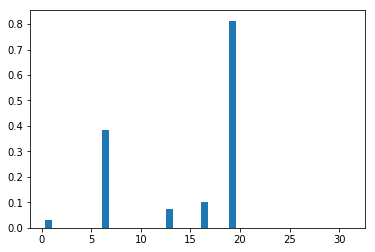

In [14]:
# Now let's plot the distribution using matplotlib.
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(centers, bins=centers, weights=marginal)
plt.show()